## Airline Tweets data analysis using Data-Prep

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from dataprep.eda import create_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
from gensim.utils import tokenize
import pandas as pd
from textblob import TextBlob


In [23]:
df = pd.read_csv('../data/train_data.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,username,text,airline_name,airline_sentiment,tweet_location,tweet_hastags,mentions,tweets,tweets_tags
0,cairdin,@VirginAmerica What @dhepburn said.,Virgin America,neutral,NaN,[],"['VirginAmerica', 'dhepburn']",what say,"[('what', 'WP'), ('say', 'VBP')]"
1,jnardino,@VirginAmerica plus you've added commercials t...,Virgin America,positive,NaN,[],['VirginAmerica'],pl you ve add commerce to the expert tack,"[('plus', 'CC'), ('you', 'PRP'), ('ve', 'VBP')..."
2,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,Virgin America,neutral,Lets Play,[],['VirginAmerica'],i do not today must mean i need to take not trip,"[('I', 'PRP'), ('do', 'VBP'), ('not', 'RB'), (..."
3,jnardino,@VirginAmerica it's really aggressive to blast...,Virgin America,negative,NaN,[],['VirginAmerica'],it really address to blast obnoxi entertain in...,"[('its', 'PRP$'), ('really', 'RB'), ('aggressi..."
4,jnardino,@VirginAmerica and it's a really big bad thing...,Virgin America,negative,NaN,[],['VirginAmerica'],and it a really big bad thing about it,"[('and', 'CC'), ('its', 'PRP$'), ('a', 'DT'), ..."


In [24]:
stopwords_lda = pd.read_csv('stopwords_lda.csv')

def preprocess(text):
    
    stopwords = set(STOPWORDS)
    
    # Appending new airline related stop-words
    stopwords.update([str(i).lower() for i in stopwords_lda.name]) 
    
    # Filter for mentions
    mentions_filter = re.compile(r'(?<=\@)(\w+)')
    
    # Filter for hash-tags
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')
    
    # Filter for flights numbers
    flight_numbers = re.compile(r'(flt\d*)')
    
    # Finding all mentions
    all_mentions = mentions_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_hashtag = hashtags_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_flights = flight_numbers.findall(text.lower())
    
    word_lemmatize = WordNetLemmatizer()
    
    # Stemming 
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(word_lemmatize.lemmatize(item,'v'))
        return lemmatized
    
    # De-emojify tweets to text
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    
    # Removing punctuation
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)
    
    # Tokenize words
    word_tokens = nltk.word_tokenize(text)
    
    # Keeping the words with length between 4 and 15
    filtered_tokens = [x for x in word_tokens if len(x)>4 and len(x)<15]
    
    # Filter tokens
    tokens = stem_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions) 
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]
    
    return all_tokens

In [25]:
df['text_tokenized']=df['text'].astype("string").map(preprocess)

In [26]:
df['tweets_len'] = df['tweets'].astype(str).apply(len)
df['tweets_word_count'] = df['tweets'].apply(lambda x: len(str(x).split()))
df.head()

,username,text,airline_name,airline_sentiment,tweet_location,tweet_hastags,mentions,tweets,tweets_tags,text_tokenized,tweets_len,tweets_word_count
0,cairdin,@VirginAmerica What @dhepburn said.,Virgin America,neutral,NaN,[],"['VirginAmerica', 'dhepburn']",what say,"[('what', 'WP'), ('say', 'VBP')]",[],8,2
1,jnardino,@VirginAmerica plus you've added commercials t...,Virgin America,positive,NaN,[],['VirginAmerica'],pl you ve add commerce to the expert tack,"[('plus', 'CC'), ('you', 'PRP'), ('ve', 'VBP')...","[add, commercials, experience, tacky]",41,9
2,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,Virgin America,neutral,Lets Play,[],['VirginAmerica'],i do not today must mean i need to take not trip,"[('I', 'PRP'), ('do', 'VBP'), ('not', 'RB'), (...",[another],48,12
3,jnardino,@VirginAmerica it's really aggressive to blast...,Virgin America,negative,NaN,[],['VirginAmerica'],it really address to blast obnoxi entertain in...,"[('its', 'PRP$'), ('really', 'RB'), ('aggressi...","[aggressive, blast, obnoxious, entertainment, ...",92,16
4,jnardino,@VirginAmerica and it's a really big bad thing...,Virgin America,negative,NaN,[],['VirginAmerica'],and it a really big bad thing about it,"[('and', 'CC'), ('its', 'PRP$'), ('a', 'DT'), ...",[],38,9


### Adding polarity to the tweets

In [27]:
df['polarity'] = df['text'].map(lambda text: TextBlob(text).sentiment.polarity)
df.head()

,username,text,airline_name,airline_sentiment,tweet_location,tweet_hastags,mentions,tweets,tweets_tags,text_tokenized,tweets_len,tweets_word_count,polarity
0,cairdin,@VirginAmerica What @dhepburn said.,Virgin America,neutral,NaN,[],"['VirginAmerica', 'dhepburn']",what say,"[('what', 'WP'), ('say', 'VBP')]",[],8,2,0.000000
1,jnardino,@VirginAmerica plus you've added commercials t...,Virgin America,positive,NaN,[],['VirginAmerica'],pl you ve add commerce to the expert tack,"[('plus', 'CC'), ('you', 'PRP'), ('ve', 'VBP')...","[add, commercials, experience, tacky]",41,9,0.000000
2,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,Virgin America,neutral,Lets Play,[],['VirginAmerica'],i do not today must mean i need to take not trip,"[('I', 'PRP'), ('do', 'VBP'), ('not', 'RB'), (...",[another],48,12,-0.390625
3,jnardino,@VirginAmerica it's really aggressive to blast...,Virgin America,negative,NaN,[],['VirginAmerica'],it really address to blast obnoxi entertain in...,"[('its', 'PRP$'), ('really', 'RB'), ('aggressi...","[aggressive, blast, obnoxious, entertainment, ...",92,16,0.006250
4,jnardino,@VirginAmerica and it's a really big bad thing...,Virgin America,negative,NaN,[],['VirginAmerica'],and it a really big bad thing about it,"[('and', 'CC'), ('its', 'PRP$'), ('a', 'DT'), ...",[],38,9,-0.350000


### Data Prep - Create Report 

In [37]:
# Attached html file can be viewed on desktop. 
report = create_report(df)
report.show_browser()

array([[<AxesSubplot:title={'center':'tweets_len'}>,
        <AxesSubplot:title={'center':'tweets_word_count'}>],
       [<AxesSubplot:title={'center':'polarity'}>, <AxesSubplot:>]],
      dtype=object)

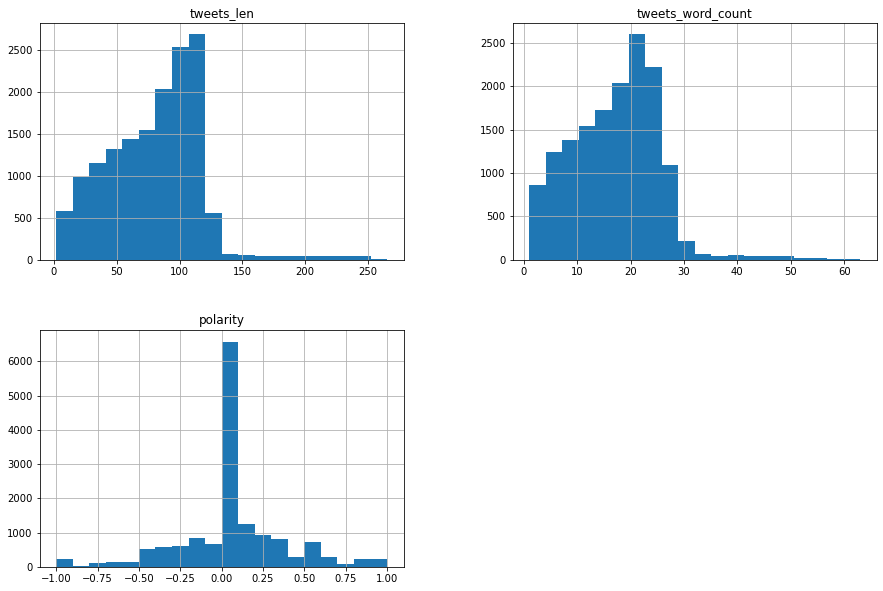

In [29]:
df[["tweets_len", "tweets_word_count", "polarity"]].hist(bins=20, figsize=(15, 10))

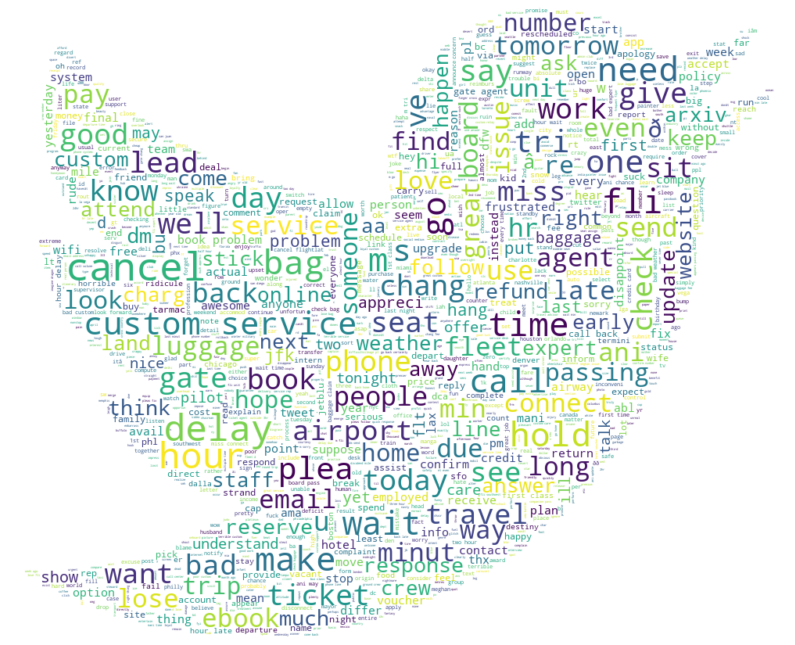

In [30]:
mask = np.array(Image.open('./twitter_mask.png'))
text = " ".join(review for review in df.tweets)
stopwords = set(STOPWORDS)
eda_stop_words = pd.read_csv('../data/eda.csv')
stopwords.update(eda_stop_words['words'].tolist())

wordcl = WordCloud(stopwords = stopwords,mask = mask,background_color='white', max_font_size = 50, max_words = 5000).generate(text)
plt.figure(figsize=(14, 12))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()